In [ ]:
import sys
sys.setrecursionlimit(2000)

In [ ]:
import math
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.model_selection import train_test_split


In [ ]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data(%s) | grad(%s) }" % (n.label, n.data.shape, n.grad.shape), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
class Value():
  def __init__(self,data,_children=(),_op='',label=''):
    self.data=data if torch.is_tensor(data) else torch.tensor(data,dtype=float)
    self._prev=set(_children)
    self._op=_op
    self.label=label
    self.grad=torch.zeros_like(self.data)
    self._backward=lambda:None

  def __repr__(self):
    return(f"Value(data={self.data})")

  def __add__(self,other):
    other=other if isinstance (other,Value) else Value(other)
    out=Value(self.data+other.data,(self,other),'+')

    def _backward():
      if(self.data.shape==other.data.shape):
        self.grad+=1.0 * out.grad
        other.grad+=1.0* out.grad
      else:
        result=self.broadcast_check(other)
        if len(result[0])==0:
          self.grad+=1.0*out.grad
        else:
          self.grad+=out.grad.sum(dim=result[0],keepdim=False).reshape(self.grad.shape)

        if len(result[1])==0:
          other.grad+=1.0*out.grad
        else:
          other.grad+=out.grad.sum(dim=result[1],keepdim=False).reshape(other.grad.shape)

    out._backward = _backward
    return out


  def __sub__(self,other):
    other=other if isinstance (other,Value) else Value(other)
    out=Value(self.data-other.data,(self,other),'-')

    def _backward():
      if(self.data.shape==other.data.shape):
        self.grad+=1.0 * out.grad
        other.grad+=-1.0* out.grad
      else:
        result=self.broadcast_check(other)
        if len(result[0])==0:
          self.grad+=1.0*out.grad
        else:
          self.grad+=out.grad.sum(dim=result[0],keepdim=False).reshape(self.grad.shape)

        if len(result[1])==0:
          other.grad+=-1.0*out.grad
        else:
          other.grad+=-out.grad.sum(dim=result[1],keepdim=False).reshape(other.grad.shape)

    out._backward=_backward
    return out


  def __mul__(self,other):
    other=other if isinstance (other,Value) else Value(other)
    out=Value(self.data*other.data,(self,other),'*')

    def _backward():
      # self.grad+=other.data * out.grad
      # other.grad+=self.data * out.grad
      if(self.data.shape==other.data.shape):
        self.grad+=other.data * out.grad
        other.grad+=self.data * out.grad
      else:
        result=self.broadcast_check(other)
        if len(result[0])==0:
          self.grad+=other.data * out.grad
        else:
          self.grad+=(other.data * out.grad).sum(dim=result[0],keepdim=False).reshape(self.grad.shape)

        if len(result[1])==0:
          other.grad+=self.data * out.grad
        else:
          other.grad+=(self.data * out.grad).sum(dim=result[1],keepdim=False).reshape(other.grad.shape)

    out._backward=_backward
    return out

  def __pow__(self,other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad+=other*(self.data**(other-1)) * out.grad

    out._backward=_backward
    return out

  def __matmul__(self,other):
    out=Value(self.data@other.data,(self,other),'@')

    def _backward():
      self.grad+=out.grad@other.data.T
      other.grad+=self.data.T@out.grad

    out._backward=_backward
    return out

  def mean(self,dim=None):
    if dim is None:
      out=Value(self.data.mean(),(self,),'mean')
    else:
      out=Value(self.data.mean(dim=dim,keepdim=False),(self,),'mean')

    def _backward():
      self.grad+=(torch.ones_like(self.data)*out.grad)/len(self.data)

    out._backward=_backward
    return out

  def __neg__(self):
    return self*-1

  def __truediv__(self,other):
    return self * other**-1

  def __radd__(self,other):
    return self+other

  def __rsub__(self,other):
    return self-other

  def __rmul__(self,other):
    return self*other

  def __rtruediv__(self,other):
    return self * other**-1

  def broadcast_check_matmul

  def broadcast_check(self,other):
    c = self.data.shape
    d = other.data.shape

    max_len = max(len(c), len(d))
    c = (1,) * (max_len - len(c)) + c
    d = (1,) * (max_len - len(d)) + d

    result={
        0:[],
        1:[]
    }
    for i, (dim_a, dim_b) in enumerate(zip(c, d)):
        if dim_a == dim_b:
            pass
        elif dim_a == 1:
            result[0].append(i)
        elif dim_b == 1:
            result[1].append(i)

    return result

  def backward(self):
    if self.data.dim()!=0:
      raise RuntimeError("Cant perform backward on non scalar")
    else:
      topo=[]
      visited=set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
      build_topo(self)
      for node in reversed(topo):
        node.grad=torch.zeros_like(node.data)
      self.grad=torch.ones_like(self.grad)
      for node in reversed(topo):
        node._backward()

In [ ]:
x=Value(torch.tensor([1.0, 2.0, 3.0, 4.0]).view(4, 1),label='x')
y=Value(torch.tensor([2.0,3.0,4.0,5.0]).view(4, 1),label='y')
w=Value(torch.tensor([[2.0]]),label='w')
b=Value(torch.tensor([[1.0]]),label='b')

In [ ]:
z=x@w+b;z.label='z'
l=((z-y)**2).mean();l.label='l'

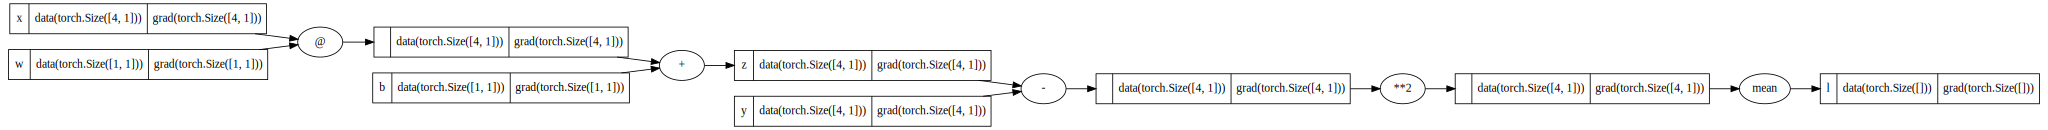

In [ ]:
draw_dot(l)

In [ ]:
l.backward()

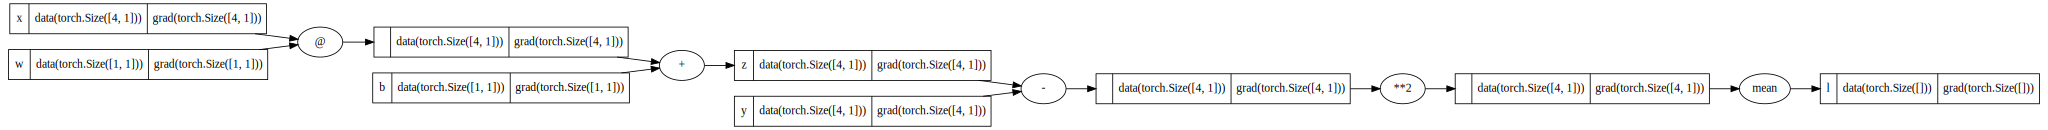

In [ ]:
draw_dot(l)

In [ ]:
xx=torch.tensor([1.0, 2.0, 3.0, 4.0]).view(4, 1)
yy=torch.tensor([2.0,3.0,4.0,5.0]).view(4, 1)
ww=torch.tensor([[2.0]])
ww.requires_grad_(True)
bb=torch.tensor([[1.0]])
bb.requires_grad_(True)

tensor([[1.]], requires_grad=True)

In [ ]:
zz=xx@ww+bb
ll=((zz-yy)**2).mean()

In [ ]:
ll.shape

torch.Size([])

In [ ]:
zz.retain_grad()
ll.backward()

In [ ]:
cmp("z",z.grad,zz)
cmp("w",w.grad,ww)
cmp("b",b.grad,bb)

z               | exact: True  | approximate: True  | maxdiff: 0.0
w               | exact: True  | approximate: True  | maxdiff: 0.0
b               | exact: True  | approximate: True  | maxdiff: 0.0


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/data.csv")

In [ ]:
columns=df.columns

In [ ]:
data=torch.tensor(df[columns[1:]].values,dtype=torch.float32)
output=torch.tensor([df[columns[0]].values],dtype=torch.float32).view(545,1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, output, test_size=0.2, random_state=42)

In [ ]:
w=torch.randn(X_train.shape[1],1,requires_grad=True)
b=torch.randn(1,1,requires_grad=True)

In [ ]:
auto_z=X_train@w+b
auto_loss=((auto_z-y_train)**2).mean()
auto_z.retain_grad()
auto_loss.backward()


In [ ]:
X_train=Value(X_train);X_train.label="X_train"
y_train=Value(y_train);y_train.label="y_train"
X_test=Value(X_test)
y_test=Value(y_test)

In [ ]:
X_train.data.shape,y_train.data.shape

(torch.Size([436, 14]), torch.Size([436, 1]))

In [ ]:
weight=Value(w.clone());weight.label="w"
bias=Value(b.clone());bias.label="b"

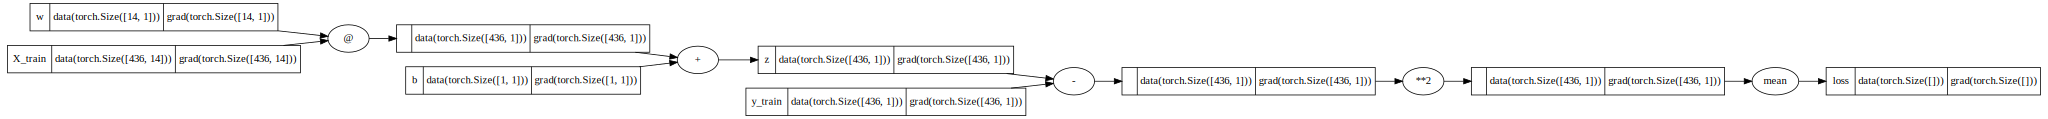

In [ ]:
z=X_train@weight+bias;z.label="z"
loss=((z-y_train)**2).mean();loss.label="loss"
draw_dot(loss)


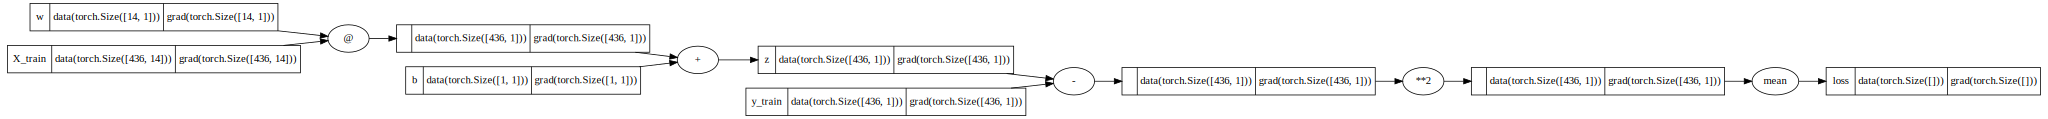

In [ ]:
loss.backward()
draw_dot(loss)

In [ ]:
cmp("z",z.grad,auto_z)
cmp("weight",weight.grad,w)
cmp("bias",bias.grad,b)

z               | exact: True  | approximate: True  | maxdiff: 0.0
weight          | exact: True  | approximate: True  | maxdiff: 0.0
bias            | exact: True  | approximate: True  | maxdiff: 0.0


In [ ]:
weight=Value(torch.randn(X_train.data.shape[1],1))
b=Value(torch.randn(1,1))

alpha=0.01

In [ ]:
loss_list=[]
Valloss_list=[]
for i in range(1500):
  z=X_train@weight+bias
  loss=((z-y_train)**2).mean()
  loss_list.append(loss.data.item())
  loss.backward()

  weight=weight-alpha*weight.grad
  bias=bias - alpha * bias.grad

  z=X_test@weight+bias
  loss=((z-y_test)**2).mean()
  Valloss_list.append(loss.data.item())

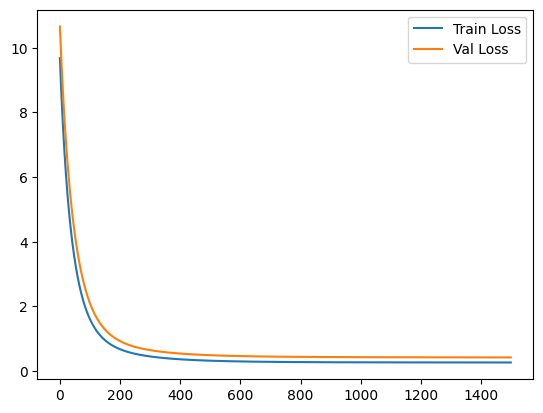

In [ ]:
plt.plot(loss_list,label="Train Loss")
plt.plot(Valloss_list,label="Val Loss")
plt.legend()

In [ ]:
y_pred = X_test @ weight + bias

ss_res = torch.sum((y_test.data-y_pred.data ) ** 2)
ss_tot = torch.sum((y_test.data - y_test.data.mean()) ** 2)


r2 = 1 - ss_res / ss_tot
print(f"R²: {r2.item()}")

R²: 0.6825824975967407
